### Resumiendo todo el proceso de experimentación en un solo cuaderno

La idea es entrenar modelos con 12 o 40 MFFCs, luego observar en el caso de 12 MFCCs (por causa del tiempo que toma), cuales son los coeficientes más preponderantes en la clasificación de 4 expresiobes importantes para el proyecto: neutral-calma y enojo-disgusto.

In [1]:
!pip install lime
!pip install shap

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
import time
import os
import librosa
import numpy as np
import tensorflow

### SEED configuration
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

#!pip install keras-tuner  # en caso de necesitar instalarlo
#import keras_tuner as kt
from sklearn.model_selection import RandomizedSearchCV
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_classification
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

Cargando los MFCCs de 1440 audios  y 8 clases. (Aproximadamente 180 audios por clase)

In [3]:
filename = 'processed_data/mfccs_big_and_small.npy'
with open(filename, 'rb') as f:
    Xb = np.load(f)
    yb = np.load(f)
    Xs = np.load(f)
    ys = np.load(f)
# Check that we've recovered the right data
print(f'Xb:{Xb.shape}, yb:{yb.shape}')
print(f'Xs:{Xs.shape}, ys:{ys.shape}')

Xb:(1440, 40), yb:(1440,)
Xs:(1440, 12), ys:(1440,)


### Desbalanceo en la clase neutral

In [4]:
label_conversion = {'1': 'neutral',
                     '2': 'calm',
                     '3': 'happy',
                     '4': 'sad',
                     '5': 'angry',
                     '6': 'fearful',
                     '7': 'disgust',
                     '8': 'surprised'}

Observando:

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

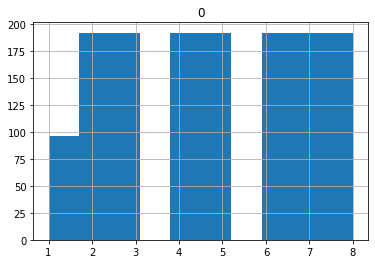

In [5]:
y_df = pd.DataFrame(ys)
y_df.hist()

Calculando los pesos para entrenar un modelo random forest con pesos

In [6]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(Xb, yb, test_size=0.10, random_state=42)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(Xs, ys, test_size=0.10, random_state=42)

### Comenzando el análisis con 12 coeficientes

In [7]:
model = RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=1800,class_weight='balanced')
model.fit(X_train_s,y_train_s)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=20,
                       n_estimators=1800)

/usr/local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


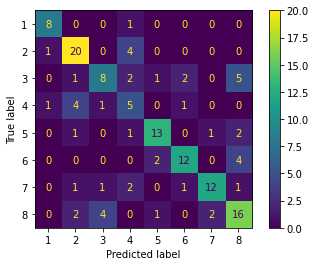

In [8]:
plot_confusion_matrix(model, X_test_s, y_test_s)
plt.show() 

### Tuning

In [9]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1500, stop = 2500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [1500, 1611, 1722, 1833, 1944, 2055, 2166, 2277, 2388, 2500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [10]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(class_weight='balanced')
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_s, y_train_s)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1500, 1611, 1722, 1833,
                                                         1944, 2055, 2166, 2277,
                                                         2388, 2500]},
                   random_state=42, verbose=2)

Los mejores parámetros obtenidos son

In [11]:
rf_random.best_params_

{'n_estimators': 1944,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

### Evaluando la mejora

In [12]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [13]:
# Baseline
base_model = RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=1800,class_weight='balanced')

# Base Accuracy
base_model.fit(X_train_s, y_train_s)
base_accuracy = evaluate(base_model, X_test_s, y_test_s)

# Best Model by Random Search
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_s, y_test_s)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.9722 degrees.
Accuracy = 74.80%.
Model Performance
Average Error: 0.9792 degrees.
Accuracy = 74.02%.
Improvement of -1.04%.


### Realizando el mismo proceso con 40 coeficientes

In [14]:
model = RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=1800,class_weight='balanced')
model.fit(X_train_b,y_train_b)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=20,
                       n_estimators=1800)

/usr/local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


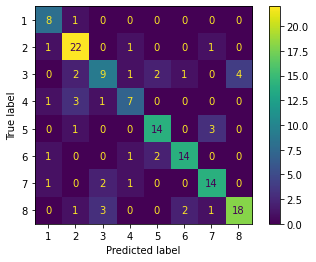

In [15]:
plot_confusion_matrix(model, X_test_b, y_test_b)
plt.show() 

In [20]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(class_weight='balanced')
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_b, y_train_b)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1500, 1611, 1722, 1833,
                                                         1944, 2055, 2166, 2277,
                                                         2388, 2500]},
                   random_state=42, verbose=2)

Utilizando más MFCCs cambia la distribución de los mejores parámetros obteniendo:

In [21]:
rf_random.best_params_

{'n_estimators': 1611,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [22]:
# Baseline
base_model = RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=1800,class_weight='balanced')

# Base Accuracy
base_model.fit(X_train_b, y_train_b)
base_accuracy = evaluate(base_model, X_test_b, y_test_b)

# Best Model by Random Search
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_b, y_test_b)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.7778 degrees.
Accuracy = 81.58%.
Model Performance
Average Error: 0.7639 degrees.
Accuracy = 81.61%.
Improvement of 0.04%.


### Intentando un análisis de SHAP con 40 MFCCs en relación a la calma y el disgusto. 

Creando los nombres de los coeficientes

In [23]:
col = list()
for i in range(40):
    name = 'c'+str(i)
    col.append(name)

In [24]:
Xb_df = pd.DataFrame(Xb, columns = col)

In [25]:
Xb_df.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c30,c31,c32,c33,c34,c35,c36,c37,c38,c39
0,-712.916632,75.358159,3.621730,13.432812,6.055151,14.996539,-3.295746,3.384919,-3.657656,-1.698236,...,0.507562,-1.536800,-3.218657,-0.003591,-0.543979,-0.643697,0.043363,-1.321510,-1.759040,-1.578606
1,-703.129846,77.326490,0.811700,14.067484,8.303788,15.496743,-4.974930,4.534601,-4.316286,-4.447952,...,0.273331,-2.848086,-3.357191,0.407848,-0.573365,-1.588466,0.244208,-1.126646,-2.357637,-1.192158
2,-702.786108,75.008431,3.531222,12.218309,6.310768,11.260469,-3.783149,4.255870,-5.443272,-3.486488,...,-0.052613,-1.047554,-3.363821,-0.471607,-0.980246,-1.060577,-0.239832,-1.303470,-1.942153,-1.649498
3,-704.551649,70.019013,5.584466,13.946856,6.371682,12.725988,-2.490561,5.662441,-4.946397,-3.181764,...,-0.395063,-1.533994,-3.011586,-0.611432,-0.917090,-0.605942,0.521824,-1.710644,-1.907542,-1.765641
4,-732.367422,88.758566,6.665467,16.737361,7.218538,16.858025,-3.897938,5.073871,-6.443878,-1.111536,...,0.218540,-2.604790,-3.351783,0.544606,-1.188930,-1.647135,0.410808,-1.799680,-1.486435,-0.736792


In [26]:
X_test_b_df = pd.DataFrame(X_test_b, columns = col)

In [27]:
X_test_b_df.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c30,c31,c32,c33,c34,c35,c36,c37,c38,c39
0,-536.251254,92.255721,-7.260184,16.638079,5.525358,18.834933,-19.968775,0.410151,-16.074328,4.008135,...,-3.841538,-2.976687,-4.315437,-1.556344,-3.149603,-0.012936,-2.107487,-1.881014,-3.171852,-1.041807
1,-740.436881,91.549474,18.336580,31.336648,11.072918,23.451171,5.604482,9.802121,2.593162,0.686124,...,-0.143490,-0.859826,-1.929317,0.810811,-1.371456,-1.013018,-1.642248,0.629566,0.121958,-0.444504
2,-551.685756,83.588441,-1.258835,8.126912,-0.182136,14.700079,-16.404759,-0.906090,-18.563803,-11.216289,...,-3.039757,-0.836400,0.941859,5.862033,6.546326,6.125977,7.436320,6.458670,5.995835,7.381008
3,-636.175372,87.146134,-7.884517,10.127150,-0.848407,3.994573,-13.146501,5.135944,-13.706629,-5.002185,...,-1.288613,-1.311622,0.154844,0.218891,2.335139,4.751294,3.110523,4.057819,4.742047,2.705476
4,-540.464330,76.908962,2.425845,20.243292,-1.637381,11.062681,-5.706190,5.695498,-0.769288,-0.626422,...,-1.451554,-0.717905,-2.346692,0.343195,-0.735396,-1.296848,-0.992322,-0.539070,-0.480849,0.386345


In [28]:
X_train_b_df = pd.DataFrame(X_train_b, columns = col)

In [29]:
X_train_b_df.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c30,c31,c32,c33,c34,c35,c36,c37,c38,c39
0,-322.435541,70.003281,-30.138073,6.328707,-13.031461,-1.528015,-15.071442,-3.438101,-19.828730,-10.583504,...,-0.642406,-0.052804,-2.472009,1.493877,3.050296,-0.060517,-2.171658,0.512474,-2.197307,1.766833
1,-678.809573,69.296158,10.636091,22.329441,1.796908,15.339881,2.037446,2.743736,-1.885635,-0.410140,...,0.939368,0.142485,-1.635994,0.584405,-0.867599,-0.516509,-0.365518,-0.706713,-1.051731,-0.264466
2,-329.451355,55.109342,-30.628392,2.536098,-5.906511,8.543116,-25.620602,-3.765538,-6.615645,-13.133439,...,1.296850,3.537775,1.882038,2.992856,1.474612,1.179054,1.972214,3.589802,3.051320,3.115090
3,-753.846292,103.383461,11.537815,15.747127,8.414447,16.662205,0.516080,2.466703,-3.776105,-4.802180,...,-0.394290,-0.179136,0.497887,-0.617812,0.091738,0.728357,-0.561499,0.590341,-0.951314,-0.351507
4,-643.812396,91.187602,1.875410,11.678617,10.514145,19.477736,-4.434624,5.159741,-1.805334,-2.418495,...,0.669158,0.203192,0.412243,1.134394,-0.624888,-0.044763,0.121245,0.199277,0.357035,1.165512


# Validation Curves

In [30]:
!pip install yellowbrick

     |████████████████████████████████| 271 kB 1.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [34]:
from yellowbrick.model_selection import validation_curve 

El mejor modelo obtuvo los siguientes parámetros:
{'n_estimators': 1611,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [35]:
model_final = RandomForestClassifier(bootstrap=False, max_depth=None, n_estimators=1611,class_weight='balanced',min_samples_split = 2, min_samples_leaf = 1,max_features = 'sqrt')

Quiero medir el parámetro ```max_depth``` pues es el parámetro sensible del modelo en relación al overfitting.
```n_jobs= -1``` permite utilizar todos los nucleos del computador para realizar los cálculos de validación cruzada. 
```param_range``` es el rango de valores que será testeados sobre el parámetro ```max_depth```. El número de validaciones cruzadas realizadas es ```cv```.  

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


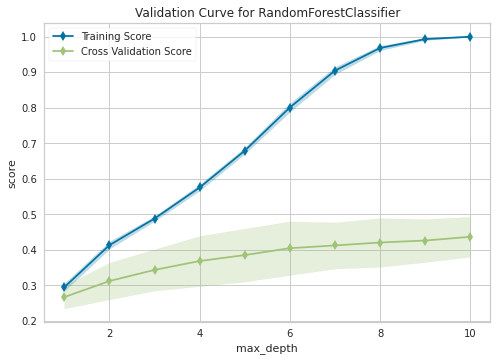

ValidationCurve(ax=<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='max_depth', ylabel='score'>,
                cv=10,
                estimator=RandomForestClassifier(bootstrap=False,
                                                 class_weight='balanced',
                                                 max_features='sqrt',
                                                 n_estimators=1611),
                n_jobs=-1, param_name='max_depth',
                param_range=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                scoring='accuracy')


In [36]:
# Plot the validation curve
print(validation_curve(model_final, Xb, yb, param_name="max_depth", n_jobs=-1,
      param_range=np.arange(1, 11), cv=10, scoring="accuracy"))

A medida que mayor es el valor de ```max_depth``` el modelo tiende al overfit. ¿Ocurrirá lo mismo con el proceso de aumentación?. ¿O con data sets de diferentes distribuciones unidos en uno solo?

# SHAP Values

Iniciando la libreria para calcular los valores SHAP 

In [ ]:
import shap
shap.initjs()

Diccionario con el nombre de las clases

In [ ]:
clases = {'1': 'neutral',
                     '2': 'calm',
                     '3': 'happy',
                     '4': 'sad',
                     '5': 'angry',
                     '6': 'fearful',
                     '7': 'disgust',
                     '8': 'surprised'}

Buscando en el conjunto de test solo los ejemplos de calma y disgusto

In [ ]:
calm_pos = []
for i in range(len(y_test_s)):
    if clases[str(y_test_s[i])]=='calm':
        calm_pos.append(i)

In [ ]:
disg_pos = []
for i in range(len(y_test_s)):
    if clases[str(y_test_s[i])]=='disgust':
        disg_pos.append(i)

Ejemplo

In [ ]:
i = calm_pos[0]
print(i)

In [ ]:
shap.initjs()
explainer = shap.KernelExplainer(best_random.predict_proba, shap.sample(X_train_b_df, 200))
shap_values = explainer.shap_values(X_test_b_df.iloc[i,:])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_b_df.iloc[i,:])

Este resultado confirma lo obtenido en la exploración inicial con la librería shap: los coeficientes $c_0$,$c_1$ y $c_2$ aparecen como siendo preponderantes en la clasificación correcta. Además, en los coeficientes superiores a 12 aparecen nuevos candidatos. 

Observemos el análisis realizado por $\mathtt{lime}$ para el mismo ejemplo

In [ ]:
import lime
import lime.lime_tabular
from __future__ import print_function

In [ ]:
classes = ['neutral', 'calm','happy', 'sad', 'angry','fearful','disgust', 'surprised']

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_b, feature_names=col, class_names=classes , discretize_continuous=True)
exp = explainer.explain_instance(X_test_b_df.iloc[calm_pos[i]], best_random.predict_proba, num_features=40, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)